In [1]:
#!pip install tensorflow-metal
#pip install tensorflow-macos

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [5]:
import tensorflow as tf
import keras.layers
from keras import layers,models
from keras.layers import Dense, Dropout
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import keras

In [6]:
pretrained_model = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


2024-09-09 12:39:26.433434: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-09 12:39:26.433449: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-09-09 12:39:26.433455: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-09-09 12:39:26.433470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 12:39:26.433480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./CottonLeafDiseaseImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1710 files belonging to 4 classes.
Using 1368 files for training.
Using 342 files for validation.


In [8]:
checkpoint_path = "cotton_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [9]:
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        #steps_per_epoch=100,
        validation_data=val_ds,
        #validation_steps=50,
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("training_logs", 
                                        "cotton_classification"),
            checkpoint_callback,
        ],
        verbose=1
    )

Saving TensorBoard log files to: training_logs/cotton_classification/20240909-123928
Epoch 1/100


2024-09-09 12:39:28.802194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-09-09 12:39:29.730566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:29.800967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:29.801003: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:39:29.802109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:29.866304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2770 - loss: 1.5894

2024-09-09 12:39:35.482270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:35.482287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2739 - loss: 1.5979

2024-09-09 12:39:35.745734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.2719 - loss: 1.6009

2024-09-09 12:39:37.835042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:37.835056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 463ms/step - accuracy: 0.2718 - loss: 1.6012 - val_accuracy: 0.2690 - val_loss: 1.5044
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.2422 - loss: 1.5651

2024-09-09 12:39:39.852157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:39.866960: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:39.866976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:39:39.910529: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:40.029432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:40.030078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:40.030087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2783 - loss: 1.5361

2024-09-09 12:39:40.729238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2844 - loss: 1.5317

2024-09-09 12:39:41.371968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:41.371983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.2853 - loss: 1.5309 - val_accuracy: 0.2982 - val_loss: 1.4375
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2812 - loss: 1.5264

2024-09-09 12:39:41.978894: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:41.999308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:42.128649: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:42.128671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.2826 - loss: 1.5101

2024-09-09 12:39:42.259070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2809 - loss: 1.5320

2024-09-09 12:39:42.799888: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:42.799919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:39:42.802015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2919 - loss: 1.5229

2024-09-09 12:39:43.477188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:43.477203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.2936 - loss: 1.5210 - val_accuracy: 0.3363 - val_loss: 1.3774
Epoch 4/100


2024-09-09 12:39:44.361804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:44.370610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:44.392887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:44.404877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:44.404911: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:39:44.470933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.3133 - loss: 1.4547

2024-09-09 12:39:45.547849: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:45.547884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3169 - loss: 1.4459

2024-09-09 12:39:46.806958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:46.806994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3174 - loss: 1.4444 - val_accuracy: 0.3977 - val_loss: 1.3230
Epoch 5/100


2024-09-09 12:39:47.761440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:47.844459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.3750 - loss: 1.3602

2024-09-09 12:39:48.067883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.3594 - loss: 1.3683

2024-09-09 12:39:48.290272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:48.317904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:48.317940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.3496 - loss: 1.3779

2024-09-09 12:39:48.554359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:48.554398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3439 - loss: 1.3875

2024-09-09 12:39:49.775042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:49.775088: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3438 - loss: 1.3876 - val_accuracy: 0.4269 - val_loss: 1.2741
Epoch 6/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3359 - loss: 1.4765

2024-09-09 12:39:50.439700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:50.439714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:39:50.478659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:50.491151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:50.508671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:50.519862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.3420 - loss: 1.4426

2024-09-09 12:39:50.748664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:50.748703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3622 - loss: 1.3977

2024-09-09 12:39:52.015255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:52.015275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.3641 - loss: 1.3936 - val_accuracy: 0.4649 - val_loss: 1.2287
Epoch 7/100


2024-09-09 12:39:52.895702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:52.920243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:52.953784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:52.987831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:53.095176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:53.095215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4118 - loss: 1.2687

2024-09-09 12:39:53.790838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:53.790862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4097 - loss: 1.2697

2024-09-09 12:39:55.336853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:55.336866: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.4093 - loss: 1.2698 - val_accuracy: 0.5088 - val_loss: 1.1870
Epoch 8/100


2024-09-09 12:39:56.626709: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:56.755874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:56.777566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:39:56.850532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:56.850572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.4629 - loss: 1.2246

2024-09-09 12:39:57.324719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:57.324737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.4559 - loss: 1.2340

2024-09-09 12:39:58.240596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4535 - loss: 1.2317

2024-09-09 12:39:59.800881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:39:59.800896: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.4541 - loss: 1.2306 - val_accuracy: 0.5409 - val_loss: 1.1473
Epoch 9/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.3984 - loss: 1.2750

2024-09-09 12:40:01.019525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:01.083273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:01.092358: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4102 - loss: 1.2676

2024-09-09 12:40:01.222669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:01.404263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:01.404292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4489 - loss: 1.2390

2024-09-09 12:40:01.759851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:01.759876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4549 - loss: 1.2365

2024-09-09 12:40:03.731862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:03.731883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.4552 - loss: 1.2357 - val_accuracy: 0.5848 - val_loss: 1.1095
Epoch 10/100


2024-09-09 12:40:05.113936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:05.184267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:05.184300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:05.194356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4688 - loss: 1.2258

2024-09-09 12:40:05.375851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.4961 - loss: 1.1764

2024-09-09 12:40:05.860611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4930 - loss: 1.1716

2024-09-09 12:40:06.244707: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:06.244740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4859 - loss: 1.1718

2024-09-09 12:40:08.460276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:08.460459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.4856 - loss: 1.1718 - val_accuracy: 0.6082 - val_loss: 1.0732
Epoch 11/100


2024-09-09 12:40:09.913227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:09.932445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:10.000003: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:10.421582: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.5020 - loss: 1.1533

2024-09-09 12:40:10.981018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:10.981035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5038 - loss: 1.1515

2024-09-09 12:40:11.456320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:11.456338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5034 - loss: 1.1419

2024-09-09 12:40:13.077249: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:13.077263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.5033 - loss: 1.1410 - val_accuracy: 0.6199 - val_loss: 1.0384
Epoch 12/100


2024-09-09 12:40:14.719698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:14.730604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.5703 - loss: 1.0796

2024-09-09 12:40:15.090989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:15.136302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:15.136393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:15.236195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.5468 - loss: 1.1028

2024-09-09 12:40:16.243026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:16.243063: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5503 - loss: 1.0996

2024-09-09 12:40:18.387227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:18.387266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.5495 - loss: 1.1000 - val_accuracy: 0.6520 - val_loss: 1.0052
Epoch 13/100


2024-09-09 12:40:20.630394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.6484 - loss: 0.9607

2024-09-09 12:40:20.900148: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.6191 - loss: 0.9882

2024-09-09 12:40:21.169488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:21.169528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.5880 - loss: 1.0150

2024-09-09 12:40:22.204359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:22.263018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:22.263052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 7/11 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.5855 - loss: 1.0178

2024-09-09 12:40:22.507526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5768 - loss: 1.0287

2024-09-09 12:40:24.188674: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:24.188691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.5758 - loss: 1.0303 - val_accuracy: 0.6696 - val_loss: 0.9735
Epoch 14/100


2024-09-09 12:40:26.544614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:26.545206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:26.545216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:26.807949: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.6113 - loss: 1.0173

2024-09-09 12:40:27.328721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:27.328749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.5836 - loss: 1.0499

2024-09-09 12:40:28.187203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:28.193720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5783 - loss: 1.0517

2024-09-09 12:40:29.898680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:29.898696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step - accuracy: 0.5779 - loss: 1.0509 - val_accuracy: 0.6959 - val_loss: 0.9430
Epoch 15/100


2024-09-09 12:40:32.224561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:32.518376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:32.956224: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5703 - loss: 1.0213

2024-09-09 12:40:33.944744: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:33.944775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.5762 - loss: 1.0259

2024-09-09 12:40:34.208351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:34.208386: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.5942 - loss: 1.0081

2024-09-09 12:40:35.198277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5956 - loss: 1.0040

2024-09-09 12:40:37.759105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:37.759118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step - accuracy: 0.5954 - loss: 1.0038 - val_accuracy: 0.7105 - val_loss: 0.9137
Epoch 16/100


2024-09-09 12:40:41.505367: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:41.505408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:41.513326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:41.536936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:41.536949: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:41.540803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.6230 - loss: 0.9715

2024-09-09 12:40:43.171209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.6340 - loss: 0.9544

2024-09-09 12:40:43.854356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6233 - loss: 0.9583

2024-09-09 12:40:46.741419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:46.741434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 762ms/step - accuracy: 0.6225 - loss: 0.9588 - val_accuracy: 0.7222 - val_loss: 0.8860
Epoch 17/100
 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6348 - loss: 0.9301

2024-09-09 12:40:51.176802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:51.176842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:51.184099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.6341 - loss: 0.9322

2024-09-09 12:40:51.636070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.6348 - loss: 0.9344

2024-09-09 12:40:51.877977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:51.905298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:51.905376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 0.6380 - loss: 0.9362

2024-09-09 12:40:52.565606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6432 - loss: 0.9351

2024-09-09 12:40:54.640289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:54.640317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 572ms/step - accuracy: 0.6437 - loss: 0.9351 - val_accuracy: 0.7515 - val_loss: 0.8592
Epoch 18/100


2024-09-09 12:40:56.872519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:40:57.091016: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:57.091030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.5391 - loss: 1.0058

2024-09-09 12:40:58.397824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:40:58.397839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:40:58.564806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5625 - loss: 0.9775

2024-09-09 12:40:58.852955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.5791 - loss: 0.9636

2024-09-09 12:40:59.127446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6193 - loss: 0.9323

2024-09-09 12:41:01.509076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:01.509381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 591ms/step - accuracy: 0.6218 - loss: 0.9304 - val_accuracy: 0.7661 - val_loss: 0.8337
Epoch 19/100
 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.6543 - loss: 0.9512

2024-09-09 12:41:05.052245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:05.058823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.6609 - loss: 0.9193

2024-09-09 12:41:06.030441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.6631 - loss: 0.9130

2024-09-09 12:41:06.451074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:06.451099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 7/11 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.6636 - loss: 0.9090

2024-09-09 12:41:06.789241: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:06.789269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:06.796223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6637 - loss: 0.8993

2024-09-09 12:41:08.590011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:08.590030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 679ms/step - accuracy: 0.6635 - loss: 0.8981 - val_accuracy: 0.7865 - val_loss: 0.8094
Epoch 20/100


2024-09-09 12:41:11.801294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6328 - loss: 0.9507

2024-09-09 12:41:13.518485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:13.518564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:13.524235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.6309 - loss: 0.9572

2024-09-09 12:41:13.843655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.6571 - loss: 0.9130

2024-09-09 12:41:15.560027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:15.560375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:15.560381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6701 - loss: 0.8962

2024-09-09 12:41:17.362605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:17.362635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 704ms/step - accuracy: 0.6720 - loss: 0.8937 - val_accuracy: 0.7953 - val_loss: 0.7865
Epoch 21/100


2024-09-09 12:41:20.570661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:20.612513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:20.976069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:21.007911: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:21.007926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.7257 - loss: 0.8449

2024-09-09 12:41:23.319530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:23.319562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:23.435873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7035 - loss: 0.8555

2024-09-09 12:41:26.126604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:26.126631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 694ms/step - accuracy: 0.7027 - loss: 0.8553 - val_accuracy: 0.7953 - val_loss: 0.7641
Epoch 22/100


2024-09-09 12:41:29.604097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:30.585133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7266 - loss: 0.7857

2024-09-09 12:41:31.899098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.7248 - loss: 0.8187

2024-09-09 12:41:32.498017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.7231 - loss: 0.8249

2024-09-09 12:41:33.013307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:33.013323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:33.016928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:33.016948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7185 - loss: 0.8259

2024-09-09 12:41:35.108931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:35.108970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 729ms/step - accuracy: 0.7178 - loss: 0.8254 - val_accuracy: 0.7982 - val_loss: 0.7425
Epoch 23/100


2024-09-09 12:41:39.538499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7092 - loss: 0.8237

2024-09-09 12:41:40.642831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:40.645278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:40.778154: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:40.778169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:40.795773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:40.795800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7110 - loss: 0.8199

2024-09-09 12:41:40.927133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7130 - loss: 0.8089

2024-09-09 12:41:43.831426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:43.831452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 641ms/step - accuracy: 0.7128 - loss: 0.8083 - val_accuracy: 0.8187 - val_loss: 0.7223
Epoch 24/100


2024-09-09 12:41:46.935235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7578 - loss: 0.7633

2024-09-09 12:41:48.040041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.7637 - loss: 0.7411

2024-09-09 12:41:48.386216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:48.422383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7625 - loss: 0.7412

2024-09-09 12:41:49.212515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:49.212547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:49.225437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:49.225468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7556 - loss: 0.7475

2024-09-09 12:41:50.163497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:50.163513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.7547 - loss: 0.7484 - val_accuracy: 0.8275 - val_loss: 0.7030
Epoch 25/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7578 - loss: 0.7731

2024-09-09 12:41:51.207418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:51.207451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:51.304773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:51.330263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7435 - loss: 0.7690

2024-09-09 12:41:51.606305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:51.606318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:51.759363: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:51.764073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7349 - loss: 0.7664

2024-09-09 12:41:53.094057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:53.094072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.7354 - loss: 0.7651 - val_accuracy: 0.8304 - val_loss: 0.6848
Epoch 26/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.7891 - loss: 0.7202

2024-09-09 12:41:54.409641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:54.453457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:54.453497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:54.463240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.7754 - loss: 0.7371

2024-09-09 12:41:54.860822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:54.865629: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.7604 - loss: 0.7497

2024-09-09 12:41:55.335917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:55.335938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7683 - loss: 0.7307

2024-09-09 12:41:56.882045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:56.882059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.7683 - loss: 0.7297 - val_accuracy: 0.8392 - val_loss: 0.6671
Epoch 27/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7422 - loss: 0.7385

2024-09-09 12:41:57.802467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:57.820968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:57.820988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:41:57.896260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:57.900164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7551 - loss: 0.7019

2024-09-09 12:41:58.475341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:41:58.636595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:58.636610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7521 - loss: 0.7065

2024-09-09 12:41:59.967127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:41:59.967146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.7523 - loss: 0.7072 - val_accuracy: 0.8450 - val_loss: 0.6499
Epoch 28/100


2024-09-09 12:42:01.510385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:01.510409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:01.572327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.7969 - loss: 0.6465

2024-09-09 12:42:01.744783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:01.747933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:01.766497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:01.766540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.7730 - loss: 0.6764

2024-09-09 12:42:02.216570: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7708 - loss: 0.6994

2024-09-09 12:42:03.999744: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:03.999782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.7711 - loss: 0.6996 - val_accuracy: 0.8509 - val_loss: 0.6332
Epoch 29/100


2024-09-09 12:42:05.040443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:05.040476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:05.060993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:05.061027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.7487 - loss: 0.6991

2024-09-09 12:42:05.742629: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.7514 - loss: 0.6974

2024-09-09 12:42:06.191007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7527 - loss: 0.6972

2024-09-09 12:42:06.401992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:06.410764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7591 - loss: 0.6965

2024-09-09 12:42:07.533410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:07.533451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.7605 - loss: 0.6955 - val_accuracy: 0.8538 - val_loss: 0.6175
Epoch 30/100


2024-09-09 12:42:08.559360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:08.559379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:08.564702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:08.577788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:08.577808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:08.649932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:08.712797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8069 - loss: 0.6666

2024-09-09 12:42:09.311156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8018 - loss: 0.6617

2024-09-09 12:42:11.401824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:11.401848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.8018 - loss: 0.6614 - val_accuracy: 0.8596 - val_loss: 0.6022
Epoch 31/100


2024-09-09 12:42:12.772773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:12.800125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:12.805747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:12.805782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:12.824031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8052 - loss: 0.6727

2024-09-09 12:42:13.691103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8057 - loss: 0.6682

2024-09-09 12:42:13.922876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:13.922907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7925 - loss: 0.6634

2024-09-09 12:42:15.811026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:15.811056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.7914 - loss: 0.6628 - val_accuracy: 0.8596 - val_loss: 0.5875
Epoch 32/100


2024-09-09 12:42:16.870052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:16.881210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:16.881226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:16.905377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:16.926699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:16.971291: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.7973 - loss: 0.6801

2024-09-09 12:42:17.700151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:17.700182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8021 - loss: 0.6428

2024-09-09 12:42:20.015587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:20.015625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.8019 - loss: 0.6414 - val_accuracy: 0.8655 - val_loss: 0.5731
Epoch 33/100


2024-09-09 12:42:21.248438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:21.257285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:21.291897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.8003 - loss: 0.6323

2024-09-09 12:42:22.105152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:22.105184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.7943 - loss: 0.6321

2024-09-09 12:42:22.585235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:22.604409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:22.604452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7914 - loss: 0.6305

2024-09-09 12:42:24.188988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:24.189006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step - accuracy: 0.7913 - loss: 0.6305 - val_accuracy: 0.8713 - val_loss: 0.5592
Epoch 34/100


2024-09-09 12:42:25.752702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:25.752726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:25.861374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:25.861448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8320 - loss: 0.6042

2024-09-09 12:42:26.180723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:26.192095: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:26.200383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:26.205708: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8189 - loss: 0.5940

2024-09-09 12:42:28.795880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:28.795919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.8184 - loss: 0.5943 - val_accuracy: 0.8713 - val_loss: 0.5462
Epoch 35/100


2024-09-09 12:42:30.424341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:30.424355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:30.426853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:30.497874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7912 - loss: 0.5967

2024-09-09 12:42:30.945207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7946 - loss: 0.5936

2024-09-09 12:42:31.219927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:31.227177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:31.227203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8028 - loss: 0.5885

2024-09-09 12:42:33.229120: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:33.229137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.8034 - loss: 0.5882 - val_accuracy: 0.8743 - val_loss: 0.5338
Epoch 36/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8438 - loss: 0.5565

2024-09-09 12:42:34.509197: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:34.509229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:34.620726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.8320 - loss: 0.5727

2024-09-09 12:42:34.739127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.8228 - loss: 0.5776

2024-09-09 12:42:35.423679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:35.428141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:35.428175: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8229 - loss: 0.5751

2024-09-09 12:42:35.679162: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8261 - loss: 0.5685

2024-09-09 12:42:37.074655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:37.074693: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.8267 - loss: 0.5676 - val_accuracy: 0.8743 - val_loss: 0.5215
Epoch 37/100


2024-09-09 12:42:38.084769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:38.116734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:38.116792: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:38.118447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:38.220155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:38.220188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.8332 - loss: 0.5362

2024-09-09 12:42:39.160896: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8312 - loss: 0.5401

2024-09-09 12:42:39.395184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8260 - loss: 0.5544

2024-09-09 12:42:40.760448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:40.760470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.8260 - loss: 0.5553 - val_accuracy: 0.8801 - val_loss: 0.5100
Epoch 38/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.8594 - loss: 0.5402

2024-09-09 12:42:42.126487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:42.126504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:42.179609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8672 - loss: 0.5195

2024-09-09 12:42:42.476310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.8683 - loss: 0.5152

2024-09-09 12:42:42.725714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:42.725754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8615 - loss: 0.5237

2024-09-09 12:42:43.211904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:43.427573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8533 - loss: 0.5359

2024-09-09 12:42:44.835563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:44.835582: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.8523 - loss: 0.5373 - val_accuracy: 0.8801 - val_loss: 0.4989
Epoch 39/100


2024-09-09 12:42:45.705612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:45.706193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:45.716910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:45.716934: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:45.789431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8203 - loss: 0.5569

2024-09-09 12:42:46.035599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:46.220064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:46.220111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8238 - loss: 0.5508

2024-09-09 12:42:48.281541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:48.281597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.8243 - loss: 0.5496 - val_accuracy: 0.8830 - val_loss: 0.4880
Epoch 40/100


2024-09-09 12:42:49.519683: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:49.519711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:49.535476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.8325 - loss: 0.5512

2024-09-09 12:42:50.088433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:50.090447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:50.101433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:50.101482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.8358 - loss: 0.5465

2024-09-09 12:42:50.741665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8399 - loss: 0.5380

2024-09-09 12:42:52.104061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:52.104082: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.8404 - loss: 0.5369 - val_accuracy: 0.8860 - val_loss: 0.4774
Epoch 41/100


2024-09-09 12:42:53.088417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:53.148740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:53.160438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:53.160469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:53.160737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.8658 - loss: 0.4929

2024-09-09 12:42:54.277105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:54.277147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:54.288684: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8586 - loss: 0.4928

2024-09-09 12:42:55.628110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:55.628150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.8575 - loss: 0.4934 - val_accuracy: 0.8977 - val_loss: 0.4672
Epoch 42/100


2024-09-09 12:42:56.884618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:56.884649: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:42:56.916256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:57.063860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.8203 - loss: 0.5888

2024-09-09 12:42:57.091044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:42:57.280880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:57.280922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.8303 - loss: 0.5512

2024-09-09 12:42:57.561521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8452 - loss: 0.5177

2024-09-09 12:42:59.567472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:42:59.567516: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.8462 - loss: 0.5151 - val_accuracy: 0.8977 - val_loss: 0.4573
Epoch 43/100


2024-09-09 12:43:00.500521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:00.500557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:00.656771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:00.661287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.8418 - loss: 0.4909

2024-09-09 12:43:01.128543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8495 - loss: 0.4891

2024-09-09 12:43:01.613731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8530 - loss: 0.4867

2024-09-09 12:43:02.122526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:02.122564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8563 - loss: 0.4856

2024-09-09 12:43:03.307468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:03.307508: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.8565 - loss: 0.4857 - val_accuracy: 0.8977 - val_loss: 0.4479
Epoch 44/100


2024-09-09 12:43:04.352634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:04.355403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:04.416111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:04.438630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:04.438676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:04.461149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.8569 - loss: 0.5066

2024-09-09 12:43:05.378529: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:05.378568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8584 - loss: 0.4932

2024-09-09 12:43:06.926921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:06.926955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.8585 - loss: 0.4920 - val_accuracy: 0.9035 - val_loss: 0.4387
Epoch 45/100


2024-09-09 12:43:08.160178: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:08.166374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:08.225965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:08.225999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:08.239645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:08.306648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:08.306685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:08.330419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8588 - loss: 0.4894

2024-09-09 12:43:10.826818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:10.826837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.8595 - loss: 0.4883 - val_accuracy: 0.9064 - val_loss: 0.4299
Epoch 46/100


2024-09-09 12:43:11.973107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:12.033460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:12.033477: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:12.050996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:12.051014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:12.102610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.8859 - loss: 0.4427

2024-09-09 12:43:13.119208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:13.125631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8821 - loss: 0.4464

2024-09-09 12:43:14.931023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:14.931047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.8812 - loss: 0.4477 - val_accuracy: 0.9064 - val_loss: 0.4217
Epoch 47/100


2024-09-09 12:43:16.243208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:16.249228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:16.391913: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8611 - loss: 0.4731

2024-09-09 12:43:16.867542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:16.897020: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:16.897049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.8601 - loss: 0.4676

2024-09-09 12:43:17.557237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:17.557272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8586 - loss: 0.4666

2024-09-09 12:43:19.206410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:19.206434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.8589 - loss: 0.4658 - val_accuracy: 0.9094 - val_loss: 0.4134
Epoch 48/100


2024-09-09 12:43:20.578878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:20.719006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.8906 - loss: 0.4084

2024-09-09 12:43:20.817101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:20.817147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.8810 - loss: 0.4306

2024-09-09 12:43:21.574070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:21.589526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:21.589628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.8781 - loss: 0.4371

2024-09-09 12:43:21.826599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8753 - loss: 0.4427

2024-09-09 12:43:23.675233: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:23.675274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.8751 - loss: 0.4426 - val_accuracy: 0.9094 - val_loss: 0.4053
Epoch 49/100


2024-09-09 12:43:25.180729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:25.245175: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:25.245190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:25.268746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:25.268764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8945 - loss: 0.4139

2024-09-09 12:43:25.428612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:25.587535: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8967 - loss: 0.4195

2024-09-09 12:43:25.756929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8912 - loss: 0.4309

2024-09-09 12:43:27.885646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:27.885689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.8908 - loss: 0.4312 - val_accuracy: 0.9094 - val_loss: 0.3974
Epoch 50/100


2024-09-09 12:43:29.066435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:29.066482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:29.150676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:29.154485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:29.154504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.8594 - loss: 0.4643

2024-09-09 12:43:29.272974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:29.275110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.8659 - loss: 0.4494

2024-09-09 12:43:30.034241: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8730 - loss: 0.4349

2024-09-09 12:43:32.710631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:32.710656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.8739 - loss: 0.4335 - val_accuracy: 0.9152 - val_loss: 0.3899
Epoch 51/100


2024-09-09 12:43:34.708691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:34.722520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:34.857349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:34.857389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step - accuracy: 0.8594 - loss: 0.4104

2024-09-09 12:43:35.103082: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8724 - loss: 0.3985

2024-09-09 12:43:36.142213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:36.146651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:36.146669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8739 - loss: 0.4000

2024-09-09 12:43:37.709306: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:37.709340: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - accuracy: 0.8738 - loss: 0.4008 - val_accuracy: 0.9181 - val_loss: 0.3828
Epoch 52/100


2024-09-09 12:43:39.461453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:39.474077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:39.474098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:39.552925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.8438 - loss: 0.5037

2024-09-09 12:43:39.697048: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.8550 - loss: 0.4688

2024-09-09 12:43:40.359310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.8589 - loss: 0.4575

2024-09-09 12:43:41.071561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:41.071595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8619 - loss: 0.4471

2024-09-09 12:43:42.519097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:42.519116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.8625 - loss: 0.4456 - val_accuracy: 0.9181 - val_loss: 0.3759
Epoch 53/100


2024-09-09 12:43:44.034443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:44.034730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:44.034746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.8867 - loss: 0.4111

2024-09-09 12:43:44.584811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:44.595506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8804 - loss: 0.4138

2024-09-09 12:43:45.039158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:45.055651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:45.055691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8777 - loss: 0.4087

2024-09-09 12:43:46.983318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:46.983332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.8778 - loss: 0.4084 - val_accuracy: 0.9211 - val_loss: 0.3689
Epoch 54/100


2024-09-09 12:43:48.581737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:48.587837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:48.587852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:48.639314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.9219 - loss: 0.3942

2024-09-09 12:43:49.032266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:49.032288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9154 - loss: 0.3801

2024-09-09 12:43:49.556768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.9092 - loss: 0.3837

2024-09-09 12:43:49.816607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8992 - loss: 0.3893

2024-09-09 12:43:51.782020: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:51.782045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.8988 - loss: 0.3893 - val_accuracy: 0.9211 - val_loss: 0.3625
Epoch 55/100


2024-09-09 12:43:53.190249: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:53.190286: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.8906 - loss: 0.3715

2024-09-09 12:43:53.520167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.8887 - loss: 0.3699

2024-09-09 12:43:53.739807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:53.775772: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.8932 - loss: 0.3633

2024-09-09 12:43:54.501194: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:54.551837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:54.551877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8963 - loss: 0.3654

2024-09-09 12:43:56.840990: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:56.841073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.8962 - loss: 0.3660 - val_accuracy: 0.9298 - val_loss: 0.3562
Epoch 56/100


2024-09-09 12:43:58.545298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:43:58.583255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.8906 - loss: 0.3764

2024-09-09 12:43:58.872034: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:58.872055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:43:58.892844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:43:58.892942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.8926 - loss: 0.3765

2024-09-09 12:43:59.130980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8937 - loss: 0.3794

2024-09-09 12:44:00.285722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8942 - loss: 0.3798

2024-09-09 12:44:01.220190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:01.220211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.8942 - loss: 0.3796 - val_accuracy: 0.9298 - val_loss: 0.3499
Epoch 57/100


2024-09-09 12:44:02.321703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:02.321729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:02.339056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:02.433500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:02.461932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.8887 - loss: 0.3996

2024-09-09 12:44:02.819125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9004 - loss: 0.3741

2024-09-09 12:44:03.260554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:03.260601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9010 - loss: 0.3647

2024-09-09 12:44:04.948467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:04.948491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.9009 - loss: 0.3645 - val_accuracy: 0.9298 - val_loss: 0.3438
Epoch 58/100


2024-09-09 12:44:06.178049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:06.178073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:06.211854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9184 - loss: 0.3913

2024-09-09 12:44:06.866747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:06.910753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9168 - loss: 0.3875

2024-09-09 12:44:07.310659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:07.310697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:07.320808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9109 - loss: 0.3747

2024-09-09 12:44:08.650310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:08.650329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.9104 - loss: 0.3741 - val_accuracy: 0.9298 - val_loss: 0.3375
Epoch 59/100


2024-09-09 12:44:09.574839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:09.578823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:09.583588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:09.604725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.9297 - loss: 0.3233

2024-09-09 12:44:09.856458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:09.856510: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.9199 - loss: 0.3391

2024-09-09 12:44:10.124017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:10.124046: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9043 - loss: 0.3622

2024-09-09 12:44:12.772259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:12.772301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - accuracy: 0.9041 - loss: 0.3628 - val_accuracy: 0.9298 - val_loss: 0.3317
Epoch 60/100


2024-09-09 12:44:14.514256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.8594 - loss: 0.4143

2024-09-09 12:44:14.916958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:14.967759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.8652 - loss: 0.4023

2024-09-09 12:44:15.257984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:15.258027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.8711 - loss: 0.3925

2024-09-09 12:44:15.497887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:15.497944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:15.518664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8926 - loss: 0.3687

2024-09-09 12:44:17.806675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:17.806782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.8934 - loss: 0.3679 - val_accuracy: 0.9298 - val_loss: 0.3264
Epoch 61/100


2024-09-09 12:44:19.066592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:19.066705: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:19.161927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.9297 - loss: 0.3120

2024-09-09 12:44:19.396374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9201 - loss: 0.3248

2024-09-09 12:44:19.711656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:19.812778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:19.812815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9167 - loss: 0.3283

2024-09-09 12:44:20.064969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9073 - loss: 0.3407

2024-09-09 12:44:22.083811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:22.083835: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.9073 - loss: 0.3406 - val_accuracy: 0.9298 - val_loss: 0.3210
Epoch 62/100


2024-09-09 12:44:23.163209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:23.195810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8965 - loss: 0.3287

2024-09-09 12:44:23.660704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.9017 - loss: 0.3320

2024-09-09 12:44:24.151467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:24.151492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9018 - loss: 0.3326

2024-09-09 12:44:24.412382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:24.412416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:24.619830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9030 - loss: 0.3350

2024-09-09 12:44:25.785067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:25.785092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.9033 - loss: 0.3349 - val_accuracy: 0.9298 - val_loss: 0.3153
Epoch 63/100


2024-09-09 12:44:26.893659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:26.893690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:26.923939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:26.957587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:27.002447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9075 - loss: 0.3493

2024-09-09 12:44:28.036942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:28.036985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:28.240045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9103 - loss: 0.3434

2024-09-09 12:44:29.810234: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:29.810254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.9111 - loss: 0.3423 - val_accuracy: 0.9327 - val_loss: 0.3104
Epoch 64/100


2024-09-09 12:44:31.111699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:31.111728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:31.236688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:31.250947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.9336 - loss: 0.3000

2024-09-09 12:44:31.972564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:32.015760: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:32.015798: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.9244 - loss: 0.3077

2024-09-09 12:44:32.483838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9200 - loss: 0.3101

2024-09-09 12:44:33.849366: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:33.849405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.9194 - loss: 0.3105 - val_accuracy: 0.9327 - val_loss: 0.3055
Epoch 65/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.8984 - loss: 0.3562

2024-09-09 12:44:34.980004: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:34.980041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:35.027143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:35.161315: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:35.161334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8984 - loss: 0.3492

2024-09-09 12:44:35.377119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:35.393757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.8967 - loss: 0.3465

2024-09-09 12:44:36.094912: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9009 - loss: 0.3374

2024-09-09 12:44:37.490951: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:37.490974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9013 - loss: 0.3368 - val_accuracy: 0.9327 - val_loss: 0.3005
Epoch 66/100


2024-09-09 12:44:38.783489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:38.809737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:38.915406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9023 - loss: 0.3766

2024-09-09 12:44:39.080947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:39.080984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.9071 - loss: 0.3604

2024-09-09 12:44:39.346801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9089 - loss: 0.3524

2024-09-09 12:44:39.771452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:39.771489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9121 - loss: 0.3309

2024-09-09 12:44:41.315753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:41.315770: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.9122 - loss: 0.3297 - val_accuracy: 0.9357 - val_loss: 0.2960
Epoch 67/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.8828 - loss: 0.3527

2024-09-09 12:44:42.544928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:42.544966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:42.551063: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:42.551091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9152 - loss: 0.3097

2024-09-09 12:44:43.150890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:43.156442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9168 - loss: 0.3070

2024-09-09 12:44:43.382811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9180 - loss: 0.3075

2024-09-09 12:44:44.053800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9176 - loss: 0.3081

2024-09-09 12:44:44.976532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:44.976571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.9177 - loss: 0.3079 - val_accuracy: 0.9357 - val_loss: 0.2912
Epoch 68/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.9375 - loss: 0.2698

2024-09-09 12:44:46.592161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:46.592209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:46.790232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.9336 - loss: 0.2809

2024-09-09 12:44:46.853941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9245 - loss: 0.2954

2024-09-09 12:44:47.475223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:47.475258: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:47.491098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9211 - loss: 0.2983

2024-09-09 12:44:47.711343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9156 - loss: 0.3014

2024-09-09 12:44:49.325565: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:49.325605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.9153 - loss: 0.3015 - val_accuracy: 0.9415 - val_loss: 0.2863
Epoch 69/100


2024-09-09 12:44:50.704540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:50.704563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:50.712748: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:50.831282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:50.831328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:44:50.986850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9288 - loss: 0.3164

2024-09-09 12:44:51.499947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:51.513600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9211 - loss: 0.3149

2024-09-09 12:44:53.437357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:53.437405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.9209 - loss: 0.3144 - val_accuracy: 0.9415 - val_loss: 0.2820
Epoch 70/100


2024-09-09 12:44:54.870639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:55.164275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:55.206549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:55.206581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.8984 - loss: 0.3096

2024-09-09 12:44:55.447493: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9036 - loss: 0.3001

2024-09-09 12:44:55.880921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:55.881009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9062 - loss: 0.2954

2024-09-09 12:44:56.113132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9086 - loss: 0.2969

2024-09-09 12:44:58.039379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:58.039412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.9084 - loss: 0.2973 - val_accuracy: 0.9474 - val_loss: 0.2776
Epoch 71/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.9141 - loss: 0.2516

2024-09-09 12:44:59.689282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:59.740335: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:59.868161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:44:59.888427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:44:59.888462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9219 - loss: 0.2552

2024-09-09 12:45:00.136508: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:00.136549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9194 - loss: 0.2627

2024-09-09 12:45:00.373303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9177 - loss: 0.2825

2024-09-09 12:45:02.416698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:02.416712: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.9179 - loss: 0.2833 - val_accuracy: 0.9474 - val_loss: 0.2736
Epoch 72/100


2024-09-09 12:45:03.739272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:03.742964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:03.742993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:03.846852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9160 - loss: 0.2985

2024-09-09 12:45:04.333969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9203 - loss: 0.2917

2024-09-09 12:45:05.290421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:05.290455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:05.294800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9230 - loss: 0.2883

2024-09-09 12:45:06.476045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:06.476654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.9232 - loss: 0.2881 - val_accuracy: 0.9474 - val_loss: 0.2695
Epoch 73/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.9297 - loss: 0.2688

2024-09-09 12:45:07.718604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:07.725680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:07.748803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:07.774397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:07.774425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9264 - loss: 0.2877

2024-09-09 12:45:08.397165: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9251 - loss: 0.2905

2024-09-09 12:45:09.293640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:09.293678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9255 - loss: 0.2861

2024-09-09 12:45:10.196094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:10.196127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.9256 - loss: 0.2853 - val_accuracy: 0.9474 - val_loss: 0.2654
Epoch 74/100


2024-09-09 12:45:11.082721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:11.094450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:11.094466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9297 - loss: 0.2617

2024-09-09 12:45:11.388993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:11.389021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.9302 - loss: 0.2638

2024-09-09 12:45:12.121822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:12.128198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.9295 - loss: 0.2665

2024-09-09 12:45:12.371350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9287 - loss: 0.2732

2024-09-09 12:45:13.936322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:13.936340: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.9287 - loss: 0.2737 - val_accuracy: 0.9474 - val_loss: 0.2615
Epoch 75/100


2024-09-09 12:45:15.259313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:15.259329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 0.9609 - loss: 0.2308

2024-09-09 12:45:15.659451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:15.688230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.9531 - loss: 0.2487

2024-09-09 12:45:15.882537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:15.912436: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9469 - loss: 0.2594

2024-09-09 12:45:16.159207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:16.159231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9366 - loss: 0.2687

2024-09-09 12:45:18.338404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:18.338422: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.9360 - loss: 0.2691 - val_accuracy: 0.9474 - val_loss: 0.2574
Epoch 76/100


2024-09-09 12:45:20.061846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:20.148589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9258 - loss: 0.2813

2024-09-09 12:45:21.205255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:21.221296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:21.221332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:21.225164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9231 - loss: 0.2759

2024-09-09 12:45:22.167484: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:22.167506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9235 - loss: 0.2735

2024-09-09 12:45:24.209224: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:24.209386: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.9233 - loss: 0.2739 - val_accuracy: 0.9503 - val_loss: 0.2533
Epoch 77/100


2024-09-09 12:45:25.698689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:25.701236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:25.701545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:25.823698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:25.823745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.9271 - loss: 0.2696

2024-09-09 12:45:26.587766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:26.617376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9279 - loss: 0.2652

2024-09-09 12:45:27.095054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9265 - loss: 0.2650

2024-09-09 12:45:28.868212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:28.868264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - accuracy: 0.9263 - loss: 0.2655 - val_accuracy: 0.9503 - val_loss: 0.2497
Epoch 78/100


2024-09-09 12:45:30.807355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:30.819375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:30.851777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:30.851804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:31.106619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:31.106649: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9266 - loss: 0.2679

2024-09-09 12:45:32.614976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:32.634282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9247 - loss: 0.2695

2024-09-09 12:45:34.148706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:34.148725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.9246 - loss: 0.2695 - val_accuracy: 0.9503 - val_loss: 0.2461
Epoch 79/100


2024-09-09 12:45:35.319005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.9219 - loss: 0.2815

2024-09-09 12:45:35.641374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:35.665848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:35.665869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9240 - loss: 0.2825

2024-09-09 12:45:35.892810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9235 - loss: 0.2817

2024-09-09 12:45:36.104010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9243 - loss: 0.2776

2024-09-09 12:45:36.786816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:36.786838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9246 - loss: 0.2731

2024-09-09 12:45:38.481204: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:38.481220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.9247 - loss: 0.2723 - val_accuracy: 0.9503 - val_loss: 0.2429
Epoch 80/100


2024-09-09 12:45:40.241550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:40.241566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 6s 677ms/step - accuracy: 0.9297 - loss: 0.2249

2024-09-09 12:45:40.625891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:40.625909: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.9316 - loss: 0.2243

2024-09-09 12:45:40.932445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.9353 - loss: 0.2234

2024-09-09 12:45:41.246309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.9385 - loss: 0.2233

2024-09-09 12:45:41.925890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:41.926211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9408 - loss: 0.2260

2024-09-09 12:45:43.845308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:43.845353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.9406 - loss: 0.2270 - val_accuracy: 0.9503 - val_loss: 0.2395
Epoch 81/100


2024-09-09 12:45:45.334402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:45.334441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:45.409495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:45.458742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:45.458766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:45.584412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:45.712094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9292 - loss: 0.2688

2024-09-09 12:45:46.262761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9329 - loss: 0.2606

2024-09-09 12:45:47.709217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:47.709259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.9333 - loss: 0.2595 - val_accuracy: 0.9532 - val_loss: 0.2361
Epoch 82/100


2024-09-09 12:45:49.082356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:49.090032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - accuracy: 0.9375 - loss: 0.2342

2024-09-09 12:45:49.819379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:49.819406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.9355 - loss: 0.2421

2024-09-09 12:45:50.067294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:50.067325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9300 - loss: 0.2492

2024-09-09 12:45:50.342147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.9299 - loss: 0.2486

2024-09-09 12:45:50.779239: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9313 - loss: 0.2496

2024-09-09 12:45:52.573700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:52.573746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.9313 - loss: 0.2501 - val_accuracy: 0.9532 - val_loss: 0.2328
Epoch 83/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.9141 - loss: 0.2738

2024-09-09 12:45:53.916084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:53.916121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:53.944764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:54.123026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.9290 - loss: 0.2485

2024-09-09 12:45:54.678125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:54.822260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:54.822278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9307 - loss: 0.2489

2024-09-09 12:45:54.894759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9379 - loss: 0.2425

2024-09-09 12:45:56.883351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:56.883372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.9382 - loss: 0.2422 - val_accuracy: 0.9532 - val_loss: 0.2294
Epoch 84/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.9375 - loss: 0.2399

2024-09-09 12:45:58.460191: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.9388 - loss: 0.2378

2024-09-09 12:45:58.858328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:58.907374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:58.907413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:45:58.946784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:45:59.021913: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9402 - loss: 0.2337

2024-09-09 12:45:59.249457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:45:59.249497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9429 - loss: 0.2325

2024-09-09 12:46:01.204501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:01.204520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.9431 - loss: 0.2325 - val_accuracy: 0.9532 - val_loss: 0.2262
Epoch 85/100


2024-09-09 12:46:02.909937: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:02.909979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:02.935138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:02.957770: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:03.096166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 5s 553ms/step - accuracy: 0.9453 - loss: 0.2738

2024-09-09 12:46:03.346761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:03.346803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.9356 - loss: 0.2572

2024-09-09 12:46:04.312024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9369 - loss: 0.2503

2024-09-09 12:46:06.083586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:06.083612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.9369 - loss: 0.2495 - val_accuracy: 0.9532 - val_loss: 0.2229
Epoch 86/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9609 - loss: 0.2337

2024-09-09 12:46:07.437886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:07.460317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:07.513061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9536 - loss: 0.2316

2024-09-09 12:46:07.994213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:07.994252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:08.002625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:08.002655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9510 - loss: 0.2317

2024-09-09 12:46:08.414878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9445 - loss: 0.2322

2024-09-09 12:46:09.885458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:09.885496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.9440 - loss: 0.2321 - val_accuracy: 0.9532 - val_loss: 0.2197
Epoch 87/100


2024-09-09 12:46:11.609809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:11.609836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:11.877281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9395 - loss: 0.2168

2024-09-09 12:46:13.245362: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9376 - loss: 0.2123

2024-09-09 12:46:14.157603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:14.176916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.9375 - loss: 0.2128

2024-09-09 12:46:14.393554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:14.393594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9375 - loss: 0.2164

2024-09-09 12:46:16.166271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:16.166286: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step - accuracy: 0.9377 - loss: 0.2166 - val_accuracy: 0.9532 - val_loss: 0.2162
Epoch 88/100


2024-09-09 12:46:17.793064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:17.793169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:17.813788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:17.821206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.9453 - loss: 0.1805

2024-09-09 12:46:18.035281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9511 - loss: 0.1878

2024-09-09 12:46:18.975040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.9493 - loss: 0.1938

2024-09-09 12:46:19.264219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:19.264258: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9446 - loss: 0.2075

2024-09-09 12:46:21.134323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:21.134350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.9441 - loss: 0.2091 - val_accuracy: 0.9532 - val_loss: 0.2134
Epoch 89/100


2024-09-09 12:46:22.683592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:22.683738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.9609 - loss: 0.2307

2024-09-09 12:46:22.967853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:22.993871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:23.014759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:23.014797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:23.033714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:23.125411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9521 - loss: 0.2177

2024-09-09 12:46:25.735393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:25.735414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.9514 - loss: 0.2181 - val_accuracy: 0.9532 - val_loss: 0.2109
Epoch 90/100


2024-09-09 12:46:26.885801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:26.920264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.9219 - loss: 0.2450

2024-09-09 12:46:27.178006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9335 - loss: 0.2336

2024-09-09 12:46:28.122094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9377 - loss: 0.2282

2024-09-09 12:46:28.631343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:28.631382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:28.634503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:28.634586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9404 - loss: 0.2251

2024-09-09 12:46:29.574568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:29.574598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.9407 - loss: 0.2249 - val_accuracy: 0.9532 - val_loss: 0.2079
Epoch 91/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9297 - loss: 0.2598

2024-09-09 12:46:30.307557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:30.307576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:30.325545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:30.325571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:30.340749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:30.378466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9390 - loss: 0.2326

2024-09-09 12:46:31.197508: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.9398 - loss: 0.2293

2024-09-09 12:46:31.646822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9444 - loss: 0.2184

2024-09-09 12:46:33.215751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:33.215785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.9449 - loss: 0.2174 - val_accuracy: 0.9561 - val_loss: 0.2049
Epoch 92/100


2024-09-09 12:46:35.492478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:35.492527: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.9531 - loss: 0.2440

2024-09-09 12:46:35.854869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.9609 - loss: 0.2189

2024-09-09 12:46:36.144483: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:36.167161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.9601 - loss: 0.2120

2024-09-09 12:46:36.382533: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:36.382606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.9577 - loss: 0.2056

2024-09-09 12:46:37.146176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9546 - loss: 0.2048

2024-09-09 12:46:38.528183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:38.528221: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step - accuracy: 0.9543 - loss: 0.2044 - val_accuracy: 0.9561 - val_loss: 0.2022
Epoch 93/100


2024-09-09 12:46:39.892753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:39.911159: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:39.914273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:39.914742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:39.914761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:40.086115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:40.169084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:40.169123: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHR

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9523 - loss: 0.1976

2024-09-09 12:46:43.157728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:43.157754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.9519 - loss: 0.1980 - val_accuracy: 0.9561 - val_loss: 0.1994
Epoch 94/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.9219 - loss: 0.2758

2024-09-09 12:46:44.987738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.9366 - loss: 0.2463

2024-09-09 12:46:45.566784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:45.580699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:45.580739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:45.602289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:45.602323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.9407 - loss: 0.2333

2024-09-09 12:46:46.034462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9424 - loss: 0.2291

2024-09-09 12:46:46.276542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9457 - loss: 0.2175

2024-09-09 12:46:47.923766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:47.923789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.9463 - loss: 0.2160 - val_accuracy: 0.9591 - val_loss: 0.1969
Epoch 95/100


2024-09-09 12:46:49.448829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:49.448843: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:49.472725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:49.521299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:49.525188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.9562 - loss: 0.1811

2024-09-09 12:46:50.233208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:50.233253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9516 - loss: 0.1910

2024-09-09 12:46:50.871491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9483 - loss: 0.2009

2024-09-09 12:46:51.942704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:51.943455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.9480 - loss: 0.2020 - val_accuracy: 0.9591 - val_loss: 0.1944
Epoch 96/100


2024-09-09 12:46:52.897633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:52.897663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.9844 - loss: 0.1486

2024-09-09 12:46:53.192801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 2/11 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9727 - loss: 0.1676

2024-09-09 12:46:53.419195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.9653 - loss: 0.1773

2024-09-09 12:46:53.653218: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:53.655002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.9567 - loss: 0.1888

2024-09-09 12:46:54.122900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:54.122922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9486 - loss: 0.1979

2024-09-09 12:46:55.484674: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:55.484696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - accuracy: 0.9480 - loss: 0.1983 - val_accuracy: 0.9591 - val_loss: 0.1918
Epoch 97/100


2024-09-09 12:46:56.458718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:56.527776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:56.527806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:46:56.534833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:46:56.641454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:56.641497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.9609 - loss: 0.2075

2024-09-09 12:46:56.785273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 6/11 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9543 - loss: 0.2037

2024-09-09 12:46:57.962222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9535 - loss: 0.2013

2024-09-09 12:46:59.181423: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:46:59.181443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9536 - loss: 0.2010 - val_accuracy: 0.9591 - val_loss: 0.1891
Epoch 98/100


2024-09-09 12:47:00.400474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:00.445408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:00.445432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.9531 - loss: 0.1964

2024-09-09 12:47:00.609737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 4/11 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9575 - loss: 0.1948

2024-09-09 12:47:01.212541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.9579 - loss: 0.1930

2024-09-09 12:47:01.554496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:01.572274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:01.572312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9574 - loss: 0.1914

2024-09-09 12:47:03.233836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:03.233850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.9572 - loss: 0.1919 - val_accuracy: 0.9591 - val_loss: 0.1867
Epoch 99/100


2024-09-09 12:47:04.239217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:04.334727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:04.334762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:47:04.361678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:04.427638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:04.427673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:47:04.432618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 5/11 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9415 - loss: 0.2117

2024-09-09 12:47:05.531423: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9470 - loss: 0.2033

2024-09-09 12:47:07.335683: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:07.335701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.9475 - loss: 0.2022 - val_accuracy: 0.9591 - val_loss: 0.1846
Epoch 100/100


2024-09-09 12:47:08.561286: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:08.711824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:08.711859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.9766 - loss: 0.1608

2024-09-09 12:47:08.880827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:08.880852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-09 12:47:08.908997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-09-09 12:47:08.937336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 3/11 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.9722 - loss: 0.1617

2024-09-09 12:47:09.482187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9605 - loss: 0.1841

2024-09-09 12:47:11.769984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-09-09 12:47:11.770029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy: 0.9601 - loss: 0.1850 - val_accuracy: 0.9591 - val_loss: 0.1822


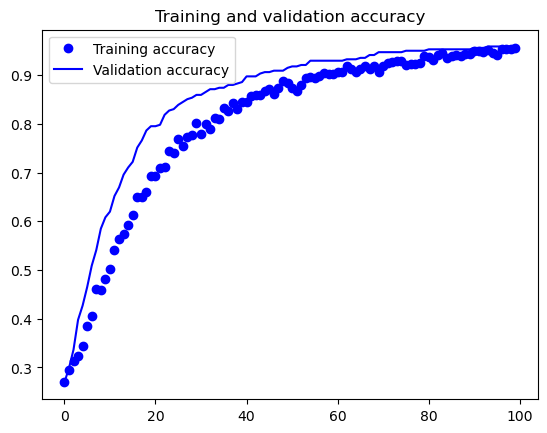

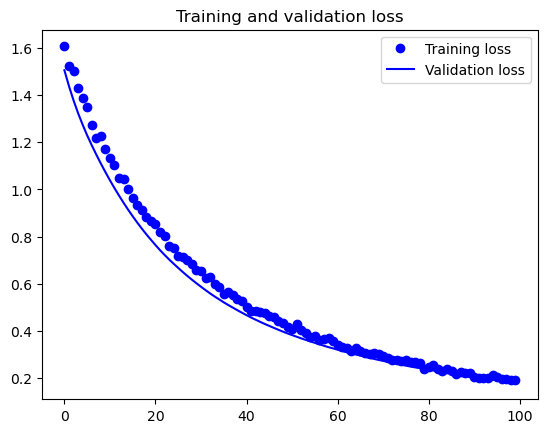

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
model.save("./models/leaf.cotton.mobilenetv3large.keras")
reconstructed_model = keras.models.load_model("./models/leaf.cotton.mobilenetv3large.keras")